# Deep Learning Course 2019
## Assignment 1:

Download the Iris data and explore it, (visualize it, how many classes, 
instances, features, etc.. Select feature number 0 and 2 and the first
100 samples and do the following analysis: 

1. Implement the logistic regression model that discussed in the class (with and
without regularization). Use Gradient descent algorithm for updating the parameters.
Plot the results.

2. Explore the influence of learning rate on the convergence of the model.
Tune the learning rate.

3. Repeat steps 1-4 for different randomly selected features (e.g. 1 and 3 or 2 
and 3. and compare the results.

4. Give the option to the users to select whatever combination of features they
want and your code will do the rest.

5.  Try your model on Monk2 dataset and report the results, (test accuracy, 
training accuracy, optimal learning rate, loss value.. Use the last 20% of the
data as test.


In [7]:
import math
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from scipy.io import loadmat
from sklearn import preprocessing

Download the dataset and explore the content. The features 0 and 2 will be used.
The dataset contains three different classes:

- Iris-setosa
- Iris-versicolor
- Iris-virginica


In [3]:
df = pd.read_csv('data/iris.data', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
print(np.unique(df[4].values))

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


We can see that the dataset is composed by instances described by four features
and that belong to a class. As it can be seen in the previous cell, there are
three possible classes.

In [3]:
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In the previous table, some data of the different columns of the dataset can
be seen, that are the features of the data.
The dataset contains 150 instances which all are complete, this is, there are not
any missing data.

In the following cell, some of the features in the dataset are plot, to have an 
overview. In this case, the first plot will represent features 0 and 2, the
second, features 1 and 3 and the last one, features 2 and 3.

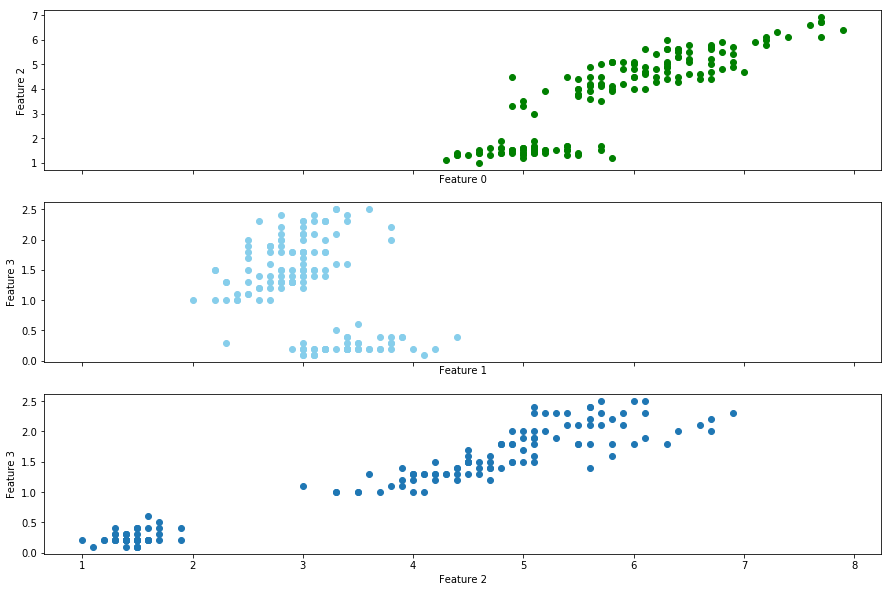

In [4]:
rcParams['figure.figsize'] = 15, 10 #To give a bigger plot

x1=df.loc[:,0]
y1=df.loc[:,2]

x2=df.loc[:,1]
y2=df.loc[:,3]

x3=df.loc[:,2]
y3=df.loc[:,3]

fig, axs = plt.subplots(3, 1, sharex='all')

# Plot each graph, and manually set the y tick values
axs[0].plot(x1, y1, 'o', color='g')
axs[0].set_ylabel('Feature 2')
axs[0].set_xlabel('Feature 0')

axs[1].plot(x2, y2, 'o',color='skyblue')
axs[1].set_ylabel('Feature 3')
axs[1].set_xlabel('Feature 1')

axs[2].plot(x3, y3,'o')
axs[2].set_ylabel('Feature 3')
axs[2].set_xlabel('Feature 2')

plt.show()

## Part 1
Implement the logistic regression model that discussed in the class
(with and without regularization). Use Gradient descent algorithm
for updating the parameters. Plot the results.

First, we are going to create the dataset that we are going to use
in this part. It will generated using the features number 0 and 2 with
the objective of predicting the output class.

The full code of this assignment can be found in the file `logistic_regression.py`
whose instructions of how to use are written in the `readme.txt` file. However, some
of the method will be explained in this notebook and used in some examples. 

In [8]:
# Method to generate the data to use from the dataset

def generate_data_with_features(data: pd.DataFrame, features: List[int], elements: int = None,
                                normalise: bool = True, test_elements: int = 0) -> \
        Tuple[Tuple[pd.DataFrame, pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Method to obtain a dataset with the features and the size desired. This
    method return the data and the class that belongs to it. If test data is desired
    the method will return two different tuples, both containing a dataframe with the
    features and other with the class.

    To retrieve correctly the data of the method, the following examples should be
    followed:

    ```
    train, test = generate_data_with_features(...)
    ```

    or

    ```
    train_x, train_y, test_x, test_y = generate_data_with_features(...)
    ```

    Normalisation are made in column by column style, using only numeric columns.

    :param data: dataframe with the original data
    :param features: list with the column name of the features
    :param elements: number of elements, when not specified the full dataset will be used
    :param normalise: flag to normalise the data
    :param test_elements: int with the number of rows to be used as test
    :return: dataframes with the new data with the desired characteristics
    """
    if elements is None:  # take full data
        elements = len(data)

    train_x = data[features][:elements]
    train_y = data.iloc[:, -1][:elements]

    if normalise:
        for i in features:
            column = train_x[i].values.reshape(-1, 1)
            if column.dtype == np.float64 or column.dtype == np.int64:
                min_max_scaler = preprocessing.MinMaxScaler()
                scaled_column = min_max_scaler.fit_transform(column)
                train_x[i] = scaled_column.reshape(-1)

    le = preprocessing.LabelEncoder()  # transform the class to 0 and 1
    train_y = le.fit_transform(train_y)

    test_x = None
    test_y = None
    if test_elements != 0 and elements > test_elements:
        train_elements = elements - test_elements
        test_x = train_x[train_elements:]
        train_x = train_x[:train_elements]
        test_y = train_y[train_elements:]
        train_y = train_y[:train_elements]

    return (pd.DataFrame(train_x).T, pd.DataFrame(train_y).T), (pd.DataFrame(test_x).T, pd.DataFrame(test_y).T)

This method generates the required data to train the logistic regression model, returning
a dataframe with the features of the data and other with the class. Therefore, for the
same row the first dataset will have the values for a given instance and the second the
class.

This method allow the normalization of the features, to improve the learning process and,
if specified,it generates the test dataset, with the same characteristics as the training one.

For the iris dataset, only the first 100 instances will be selected, in this first case using
the features 0 and 2. We will normalize the features.

In [9]:
train, test = generate_data_with_features(df, elements=100, features=[0, 2], normalise=True)

The following methods will be used to train the logistic regression model, using the
data previously generated.

In [10]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    The sigmoid function that applies to the result of the product of the weight and the activation of the
    neurons plus the biases, known as weighted input.
    z = w_l*a_l+b

    :param z: weighted input.
    :return: activation of the next layer of the network
    """
    return 1.0 / (1 + np.exp(-z))


def forward_pass(x: np.ndarray, weights: np.ndarray, bias: float) -> np.ndarray:
    """
    Method that calculates the activation of the sigmoid function
    from a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: activation of the model for each row of the input
    """
    weighted_input = np.dot(weights, x) + bias
    return sigmoid(weighted_input)


def calculate_derivatives(x: np.ndarray, y: np.ndarray, weights: np.ndarray, bias: float,
                          regularization_term: float = 0) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Method that propagates the input and calculates the cost and the derivative of the
    weights and the biases.

    :param x: features of the data
    :param y: classes of the data
    :param weights: weights of the model
    :param bias: bias of the model
    :param regularization_term: value of lambda
    :return: tuple with the cost, the derivative of the weights and bias
    """
    n_samples = y.shape[1]
    activation = forward_pass(x, weights, bias)
    cost = np.mean(-y * np.log(activation) - (1 - y) * np.log(1 - activation))
    cost = cost + regularization_term / (2 * n_samples) * np.dot(weights.T, weights)  # lambda/2m*sum(theta^2)
    dz = -(y - activation) / n_samples
    dw = np.dot(dz, x.T).squeeze()
    db = np.sum(dz)
    return cost, dw, db


def train_model(train_data: Tuple[pd.DataFrame, pd.DataFrame], epochs: int, learning_rate: float = 0.5,
                regularization_term: float = 0) -> Tuple[np.ndarray, float, np.ndarray]:
    """
    Method to train the model

    :param train_data: training data, with the features and the outputs
    :param epochs: number of epochs to train the model
    :param learning_rate: value of the learning rate, alpha
    :param regularization_term: value of the regularization term, lambda
    :return: weights and bias of the trained model. List of the costs during training
    """
    x, y = train_data  # extract the data and the classes
    n_samples = y.shape[1]
    costs = list()
    bias = 1
    weights = np.random.uniform(low=-0.7, high=0.7, size=x.shape[0])
    for epoch in range(epochs):
        cost, dw, db = calculate_derivatives(x=x.to_numpy(), y=y.to_numpy(), weights=weights,
                                             bias=bias, regularization_term=regularization_term)
        if epoch % 1000 == 0:
            print('The cost in epoch {0} was {1}'.format(epoch, cost))
        costs.append(cost)
        weights -= learning_rate * (dw + regularization_term / n_samples * weights)
        bias -= learning_rate * (db + regularization_term / n_samples * bias)
    print('Finished training, trained during {0} epochs'.format(epochs))
    return weights, bias, np.array(costs)

For getting outputs and testing we implement the following methods:

In [11]:
def predict(x: np.ndarray, weights: np.ndarray, bias: float) -> np.ndarray:
    """
    Method that outputs the system response
    of a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: output of the system for each row of the input
    """
    activation = forward_pass(x, weights, bias)
    return 1 * (activation > 0.5)


def test_model(test_data: Tuple[pd.DataFrame, pd.DataFrame], weights: np.ndarray,
               bias: float) -> float:
    """
    Method that calculates the accuracy given a test dataset.

    :param test_data: test data, with the features and the outputs
    :param weights: weights of the trained model
    :param bias: bias of the trained model
    :return: accuracy in the data
    """
    x, y = test_data
    predicted_y = predict(x.to_numpy(), weights, bias)
    diff_pred_real = abs(predicted_y - y.to_numpy().squeeze())
    percentage_error = np.count_nonzero(diff_pred_real == 1) / len(diff_pred_real)
    return 1 - percentage_error


def get_prob_and_cost(x: np.ndarray, y: np.ndarray, weights: np.ndarray,
                      bias: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Method that outputs the system response
    of a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: output of the system
    """
    activation: np.ndarray = forward_pass(x, weights, bias)
    cost: np.ndarray = -y * np.log(activation) - (1 - y) * np.log(1 - activation)
    return activation, cost.squeeze()

And for plotting the data and the results:

In [12]:
def plot_with_different_rates(train_data: Tuple[pd.DataFrame, pd.DataFrame], learning_rates: List[float],
                              regularization_terms: List[float], epochs: int = 10000, plot: bool = True) -> None:
    """
    Method that trains and plots the cost of a given training data. This method will save the
    figures in the folder 'images' with a name indicating the features used and the regularization
    term used.

    :param train_data: data to train the model, with features and class
    :param learning_rates: list of the learning rates to test
    :param regularization_terms: list of regularization rates to test
    :param epochs: number of epochs to train each combination
    :param plot: flag to show in the screen the figure
    """
    for rt in regularization_terms:
        plt.figure()
        features_used = train_data[0].T.columns.values
        features_used = "-".join(repr(i) for i in features_used)
        for lr in learning_rates:
            weights, bias, costs = train_model(train_data, epochs=epochs, learning_rate=lr, regularization_term=rt)
            plt.plot(costs, label='alpha: {0}, lambda: {1}'.format(lr, rt))
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
        plt.title('Training {0} with regularization term {1} and different learning rates'.format(features_used, rt))
        plt.legend()
        plt.savefig('./images/f-{0}_rt-{1}.png'.format(features_used, rt))
        if plot:
            plt.show()
        else:
            plt.close()


def plot_features_combinations(data: pd.DataFrame, elements: int, learning_rates: List[float],
                               regularization_terms: List[float], epochs: int = 10000,
                               test_elements: int = 0, plot: bool = False) -> None:
    """
    Method that uses all possible binary combination of parameters to train different logistic regressions
    using different learning rates and regularization rates.

    :param data: data to train the model, full dataframe
    :param elements: number of elements that will be used to train
    :param learning_rates: list of the learning rates to test
    :param regularization_terms: list of regularization rates to test
    :param epochs: number of epochs to train each combination
    :param test_elements: number of rows to be used as test
    :param plot: flag to show in the screen the figure
    """
    num_features = len(data.columns.values) - 1  # remove class
    for i in range(num_features):
        for j in range(i + 1, num_features):
            train, test = generate_data_with_features(data, features=[i, j], elements=elements,
                                                      test_elements=test_elements)
            plot_with_different_rates(train, epochs=epochs, learning_rates=learning_rates,
                                      regularization_terms=regularization_terms, plot=plot)


def plot_boundary(x: np.ndarray, y: np.ndarray, weights: np.ndarray,
                  bias: float, str_id: str, plot: bool = True) -> None:
    """
    Method that plot the data and the decision boundary of a given
    logistic regression model, using the bias term and the weights.

    :param x: features of the data
    :param y: classes of the data
    :param weights: weights of the model
    :param bias: bias of the model
    :param plot: flag to show the figure in the screen
    """
    # get the indexes of each class
    zero = np.where(y == 0)[1]
    one = np.where(y == 1)[1]

    plt.figure()
    plt.scatter(x[0][zero], x[1][zero], s=10, label='Class 0')
    plt.scatter(x[0][one], x[1][one], s=10, label='Class 1')

    # decision boundary
    x_values = [np.min(x[0, :]), np.max(x[0, :])]
    y_values = - (bias + np.dot(weights[0], x_values)) / weights[1]
    plt.plot(x_values, y_values, label='Decision Boundary')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    if str_id is None:
        str_id = "-".join(repr(i) for i in weights)

    plt.savefig('./images/boundary-{0}.png'.format(str_id))

    if plot:
        plt.show()
    else:
        plt.close()

The main method will be `train_model` that will use the training data and will require
the number of training epochs, the learning rate and the regularization term. It will
return the weights and bias for the model trained along with an array with the cost
during training. The method `predict` can be used to calculate the output for a given input, weight and
bias.

Firstly, we are going to train the model with the Iris data generated previously, using
the features 0 and 2, with a learning rate of 0.4 and a weight decay of 0.2.

In [14]:
weights, bias, costs = train_model(train, epochs=2000, learning_rate=0.4, regularization_term=0.2)
print('The accuracy in the train is {0}'.format(test_model(train, weights, bias)))

The cost in epoch 0 was 0.8055945257978526
The cost in epoch 1000 was 0.13869516981203228
Finished training, trained during 2000
The accuracy in the train is 1.0


Now, we try different values of learning rates for Gradient Descent (alphas) and regularization terms (lambdas), plotting the results of the cost for features 0 and 2.  

The cost in epoch 0 was 0.8009463906931948
The cost in epoch 500 was 0.21527387119040997
The cost in epoch 1000 was 0.1275035027667638
The cost in epoch 1500 was 0.09244226241760843
Finished training, trained during 2000
The cost in epoch 0 was 0.844772766624112
The cost in epoch 500 was 0.13044532098961756
The cost in epoch 1000 was 0.07385402260112549
The cost in epoch 1500 was 0.05305473005224142
Finished training, trained during 2000
The cost in epoch 0 was 0.871030661870044
The cost in epoch 500 was 0.09570721250937071
The cost in epoch 1000 was 0.0541573169522456
The cost in epoch 1500 was 0.03889732131201847
Finished training, trained during 2000
The cost in epoch 0 was 0.8248657047875833
The cost in epoch 500 was 0.07446590899579314
The cost in epoch 1000 was 0.04265202740839693
The cost in epoch 1500 was 0.030729825643562515
Finished training, trained during 2000
The cost in epoch 0 was 0.8343024017076356
The cost in epoch 500 was 0.061604075984197655
The cost in epoch 1000 wa

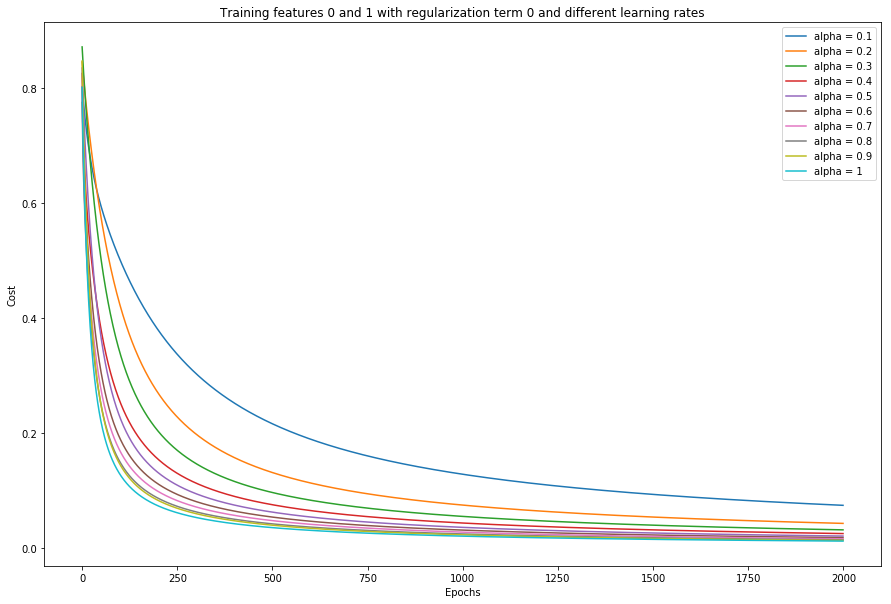

The cost in epoch 0 was 0.8219988782184943
The cost in epoch 500 was 0.32196908760976
The cost in epoch 1000 was 0.29721780065310544
The cost in epoch 1500 was 0.29349907080386856
Finished training, trained during 2000
The cost in epoch 0 was 0.7957344349037937
The cost in epoch 500 was 0.2976762738297163
The cost in epoch 1000 was 0.29289936482703316
The cost in epoch 1500 was 0.29263599986949007
Finished training, trained during 2000
The cost in epoch 0 was 0.7888658160662756
The cost in epoch 500 was 0.2939225160800435
The cost in epoch 1000 was 0.292666919812612
The cost in epoch 1500 was 0.29263637544492727
Finished training, trained during 2000
The cost in epoch 0 was 0.7997251733839785
The cost in epoch 500 was 0.29292520920812715
The cost in epoch 1000 was 0.2926311850108918
The cost in epoch 1500 was 0.292635091448435
Finished training, trained during 2000
The cost in epoch 0 was 0.8732841508591365
The cost in epoch 500 was 0.2925286738593599
The cost in epoch 1000 was 0.29262

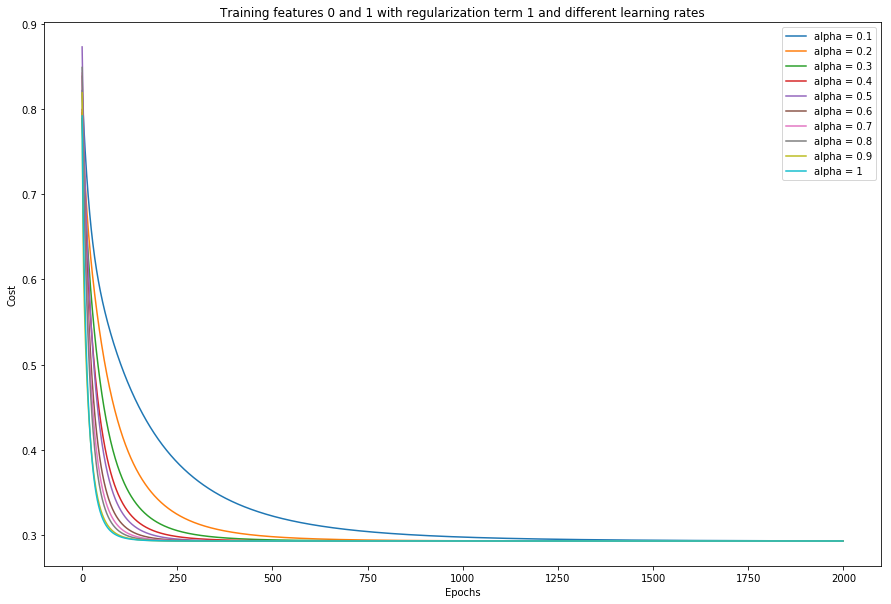

The cost in epoch 0 was 0.8126377950356017
The cost in epoch 500 was 0.5711309620410777
The cost in epoch 1000 was 0.5710665331702219
The cost in epoch 1500 was 0.571066439020959
Finished training, trained during 2000
The cost in epoch 0 was 0.857751397598918
The cost in epoch 500 was 0.5710665639173657
The cost in epoch 1000 was 0.5710664389334801
The cost in epoch 1500 was 0.5710664389335748
Finished training, trained during 2000
The cost in epoch 0 was 0.8309806881403746
The cost in epoch 500 was 0.5710664395700247
The cost in epoch 1000 was 0.5710664389335747
The cost in epoch 1500 was 0.5710664389335747
Finished training, trained during 2000
The cost in epoch 0 was 0.8156997274992103
The cost in epoch 500 was 0.571066438933304
The cost in epoch 1000 was 0.5710664389335747
The cost in epoch 1500 was 0.5710664389335747
Finished training, trained during 2000
The cost in epoch 0 was 0.8784314667311967
The cost in epoch 500 was 0.5710664389335679
The cost in epoch 1000 was 0.5710664389

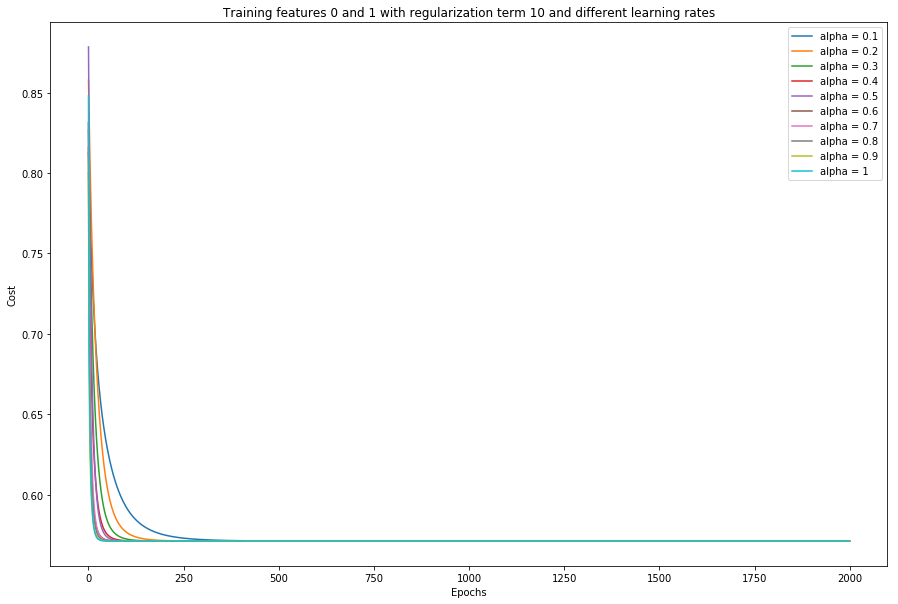

The cost in epoch 0 was 1.108323243043004
The cost in epoch 500 was 0.6765425513124789
The cost in epoch 1000 was 0.6765425513124789
The cost in epoch 1500 was 0.6765425513124789
Finished training, trained during 2000
The cost in epoch 0 was 0.854997109023104
The cost in epoch 500 was 0.6765425513124789
The cost in epoch 1000 was 0.6765425513124789
The cost in epoch 1500 was 0.6765425513124789
Finished training, trained during 2000
The cost in epoch 0 was 0.9004619921416648
The cost in epoch 500 was 0.6765425513124789
The cost in epoch 1000 was 0.6765425513124789
The cost in epoch 1500 was 0.6765425513124789
Finished training, trained during 2000
The cost in epoch 0 was 0.8170067321227509
The cost in epoch 500 was 0.6765425513124789
The cost in epoch 1000 was 0.6765425513124789
The cost in epoch 1500 was 0.6765425513124789
Finished training, trained during 2000
The cost in epoch 0 was 0.9859871404829164
The cost in epoch 500 was 0.6765425513124789
The cost in epoch 1000 was 0.676542551

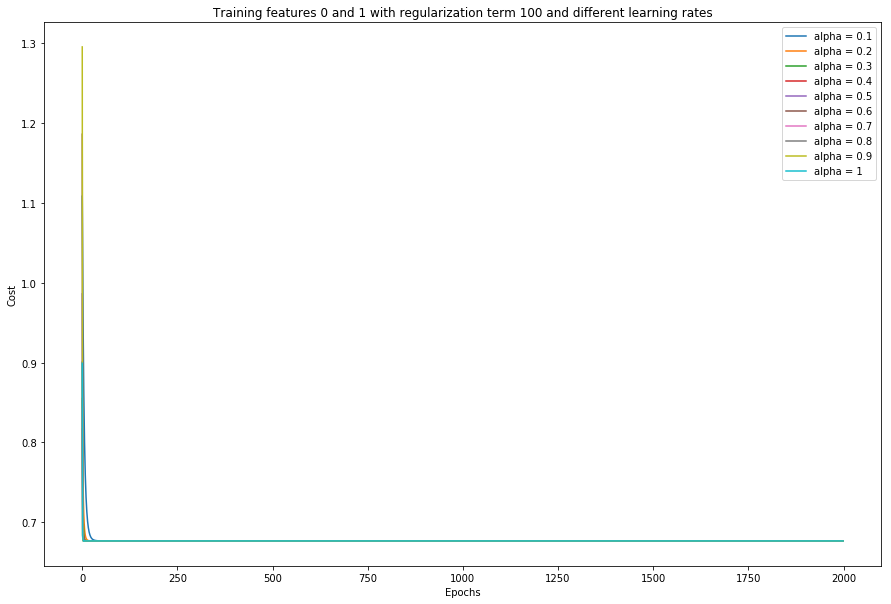

In [11]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10, 100] #Regularization term

    
for l in lambdas:
    for i in range(0,10):
        
        weights, bias, costs = train_model(train, epochs=int(2000), learning_rate=alphas[i], regularization_term=l)
        p=plt.plot(costs, label='alpha = '+str(alphas[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
    plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
    plt.legend()
    plt.show()

The bigger the learning rate, the faster it converges to the cost. However, if we add the regularization term, then our cost increases to avoid the overfitting of our model and the convergence is much faster. In the following, we compare our results for different features.

The cost in epoch 0 was 0.7821375234780333
The cost in epoch 500 was 0.35741403027763324
The cost in epoch 1000 was 0.25065089410176744
The cost in epoch 1500 was 0.19780647575486676
Finished training, trained during 2000
The cost in epoch 0 was 0.775179578187893
The cost in epoch 500 was 0.24987016481076096
The cost in epoch 1000 was 0.16566491229486277
The cost in epoch 1500 was 0.12872238564673186
Finished training, trained during 2000
The cost in epoch 0 was 0.8310105208615666
The cost in epoch 500 was 0.20126061674812704
The cost in epoch 1000 was 0.13004113948484064
The cost in epoch 1500 was 0.10046237183169289
Finished training, trained during 2000
The cost in epoch 0 was 0.8035005607635517
The cost in epoch 500 was 0.16618863585342095
The cost in epoch 1000 was 0.10761543491838416
The cost in epoch 1500 was 0.08339767805032743
Finished training, trained during 2000
The cost in epoch 0 was 0.7666164632421346
The cost in epoch 500 was 0.1435122457654907
The cost in epoch 1000 wa

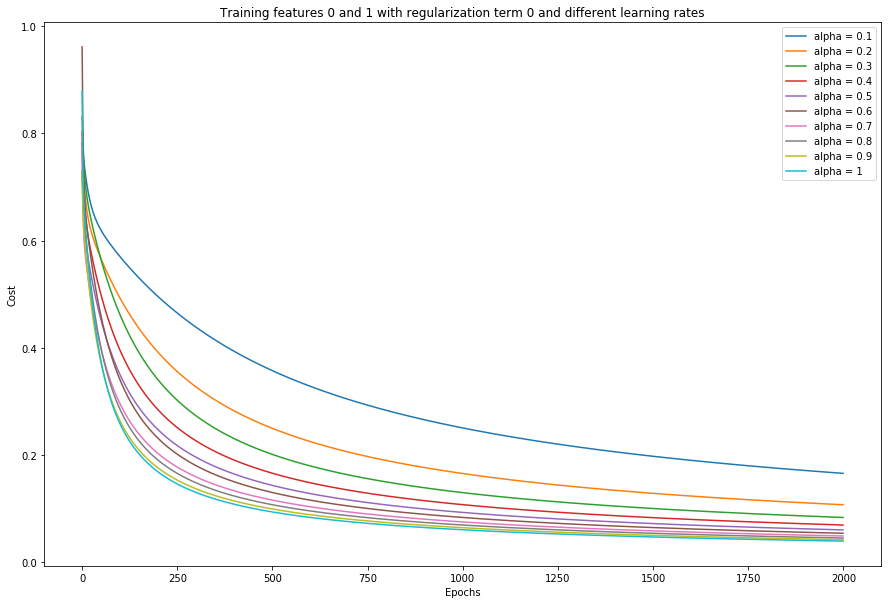

The cost in epoch 0 was 0.7968428024988607
The cost in epoch 500 was 0.4606328141798409
The cost in epoch 1000 was 0.4400968412734583
The cost in epoch 1500 was 0.4373167520722242
Finished training, trained during 2000
The cost in epoch 0 was 0.7804279651298771
The cost in epoch 500 was 0.44123644162739306
The cost in epoch 1000 was 0.43694131468669345
The cost in epoch 1500 was 0.4368446589382159
Finished training, trained during 2000
The cost in epoch 0 was 0.9529594796685099
The cost in epoch 500 was 0.43748141111232536
The cost in epoch 1000 was 0.4368418006780554
The cost in epoch 1500 was 0.4368410227234222
Finished training, trained during 2000
The cost in epoch 0 was 0.9148611236574733
The cost in epoch 500 was 0.43692314519651504
The cost in epoch 1000 was 0.4368408567735739
The cost in epoch 1500 was 0.4368412388549891
Finished training, trained during 2000
The cost in epoch 0 was 0.9274666759633559
The cost in epoch 500 was 0.43685537923296175
The cost in epoch 1000 was 0.43

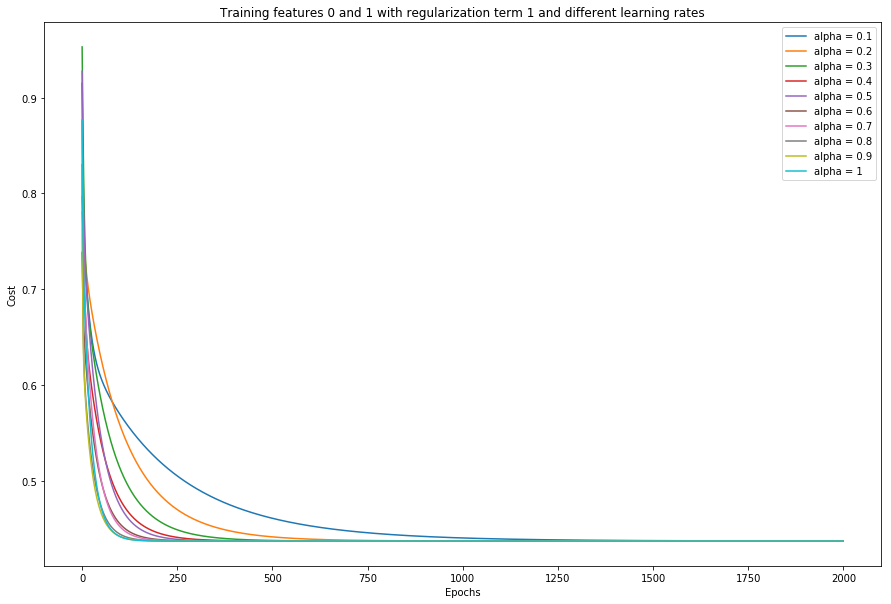

The cost in epoch 0 was 0.8783964812092014
The cost in epoch 500 was 0.6409188756821788
The cost in epoch 1000 was 0.6409133692571606
The cost in epoch 1500 was 0.6409133526362507
Finished training, trained during 2000
The cost in epoch 0 was 0.9020081275899952
The cost in epoch 500 was 0.6409133686874929
The cost in epoch 1000 was 0.6409133525648866
The cost in epoch 1500 was 0.6409133525646021
Finished training, trained during 2000
The cost in epoch 0 was 0.7592185703586416
The cost in epoch 500 was 0.6409133526998984
The cost in epoch 1000 was 0.6409133525646021
The cost in epoch 1500 was 0.640913352564602
Finished training, trained during 2000
The cost in epoch 0 was 0.8474783977686289
The cost in epoch 500 was 0.6409133525647217
The cost in epoch 1000 was 0.6409133525646021
The cost in epoch 1500 was 0.6409133525646021
Finished training, trained during 2000
The cost in epoch 0 was 0.8108349992435654
The cost in epoch 500 was 0.6409133525646027
The cost in epoch 1000 was 0.64091335

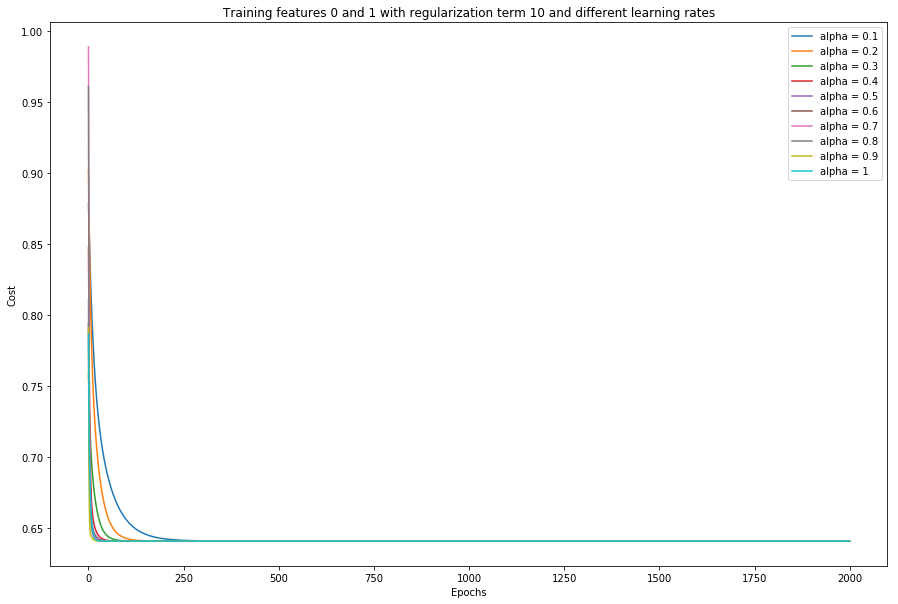

The cost in epoch 0 was 1.1595987768901133
The cost in epoch 500 was 0.6872507147632364
The cost in epoch 1000 was 0.6872507147632364
The cost in epoch 1500 was 0.6872507147632364
Finished training, trained during 2000
The cost in epoch 0 was 1.0496030124382645
The cost in epoch 500 was 0.6872507147632364
The cost in epoch 1000 was 0.6872507147632364
The cost in epoch 1500 was 0.6872507147632364
Finished training, trained during 2000
The cost in epoch 0 was 1.0103071617028125
The cost in epoch 500 was 0.6872507147632364
The cost in epoch 1000 was 0.6872507147632364
The cost in epoch 1500 was 0.6872507147632364
Finished training, trained during 2000
The cost in epoch 0 was 0.8639919918387313
The cost in epoch 500 was 0.6872507147632364
The cost in epoch 1000 was 0.6872507147632364
The cost in epoch 1500 was 0.6872507147632364
Finished training, trained during 2000
The cost in epoch 0 was 0.9843946119636661
The cost in epoch 500 was 0.6872507147632364
The cost in epoch 1000 was 0.6872507

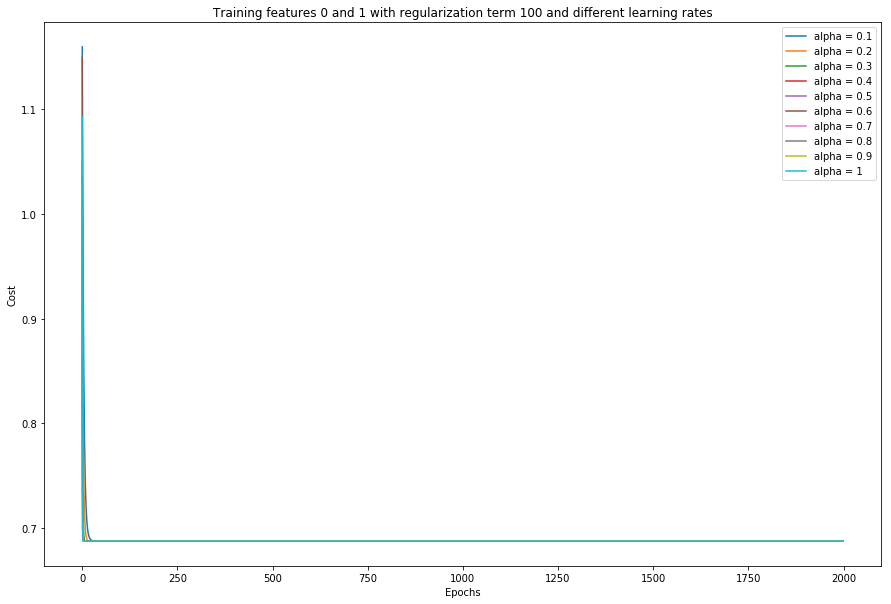

The cost in epoch 0 was 0.849726688632485
The cost in epoch 500 was 0.17307011347513146
The cost in epoch 1000 was 0.09577151353690795
The cost in epoch 1500 was 0.06640604774835807
Finished training, trained during 2000
The cost in epoch 0 was 0.8107501261931392
The cost in epoch 500 was 0.09635058750606783
The cost in epoch 1000 was 0.051214597441919
The cost in epoch 1500 was 0.0352449177834314
Finished training, trained during 2000
The cost in epoch 0 was 0.78375628360628
The cost in epoch 500 was 0.06762687106874227
The cost in epoch 1000 was 0.03551441079021394
The cost in epoch 1500 was 0.024408567927148784
Finished training, trained during 2000
The cost in epoch 0 was 0.7129008749610669
The cost in epoch 500 was 0.05047216070498752
The cost in epoch 1000 was 0.02685702587988706
The cost in epoch 1500 was 0.01857800108938195
Finished training, trained during 2000
The cost in epoch 0 was 0.7611273344435535
The cost in epoch 500 was 0.04167667030307306
The cost in epoch 1000 was 0

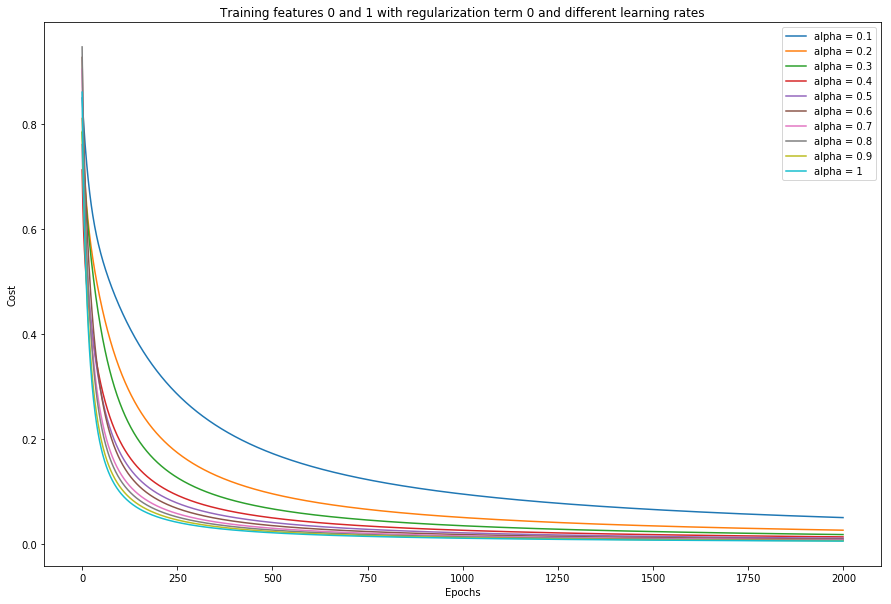

The cost in epoch 0 was 0.7788698770436837
The cost in epoch 500 was 0.30257169401627737
The cost in epoch 1000 was 0.28624714038114707
The cost in epoch 1500 was 0.28442393766376145
Finished training, trained during 2000
The cost in epoch 0 was 0.8152468780979072
The cost in epoch 500 was 0.28687392462328376
The cost in epoch 1000 was 0.2841024297498797
The cost in epoch 1500 was 0.2837768239544039
Finished training, trained during 2000
The cost in epoch 0 was 0.9335535014707347
The cost in epoch 500 was 0.2843102090069597
The cost in epoch 1000 was 0.28372624518893425
The cost in epoch 1500 was 0.28367240585523396
Finished training, trained during 2000
The cost in epoch 0 was 0.9623148267955548
The cost in epoch 500 was 0.28383973893891173
The cost in epoch 1000 was 0.28367378584033026
The cost in epoch 1500 was 0.2836636319946425
Finished training, trained during 2000
The cost in epoch 0 was 0.8402045996878381
The cost in epoch 500 was 0.2837313298595854
The cost in epoch 1000 was 0

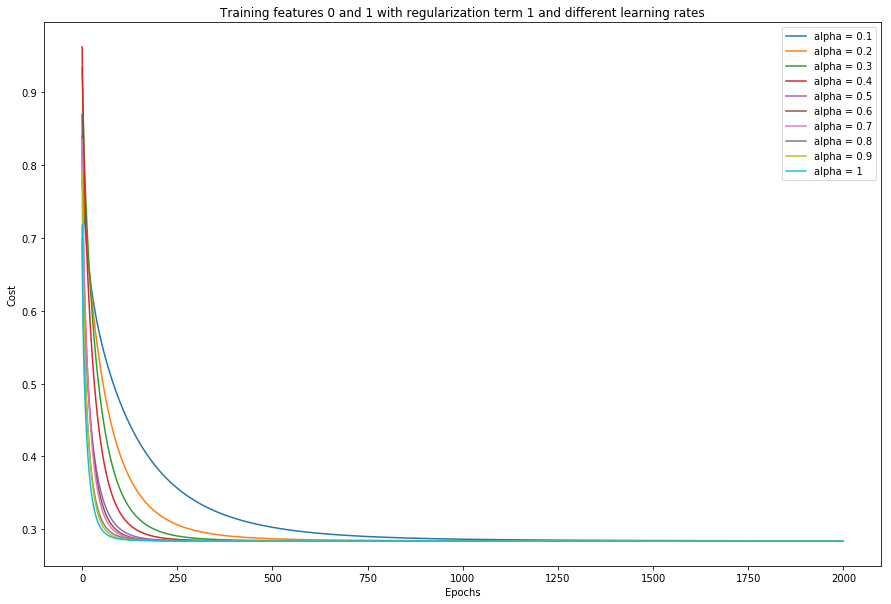

The cost in epoch 0 was 0.8640817669599214
The cost in epoch 500 was 0.5698420905481718
The cost in epoch 1000 was 0.5698154017656648
The cost in epoch 1500 was 0.5698152910176458
Finished training, trained during 2000
The cost in epoch 0 was 0.8607061591024885
The cost in epoch 500 was 0.5698154780051126
The cost in epoch 1000 was 0.5698152904626693
The cost in epoch 1500 was 0.5698152904577513
Finished training, trained during 2000
The cost in epoch 0 was 0.7524169011753384
The cost in epoch 500 was 0.5698152913532177
The cost in epoch 1000 was 0.5698152904577513
The cost in epoch 1500 was 0.5698152904577511
Finished training, trained during 2000
The cost in epoch 0 was 0.8217587095814337
The cost in epoch 500 was 0.5698152904609878
The cost in epoch 1000 was 0.5698152904577513
The cost in epoch 1500 was 0.5698152904577513
Finished training, trained during 2000
The cost in epoch 0 was 1.0223760123248518
The cost in epoch 500 was 0.5698152904577571
The cost in epoch 1000 was 0.5698152

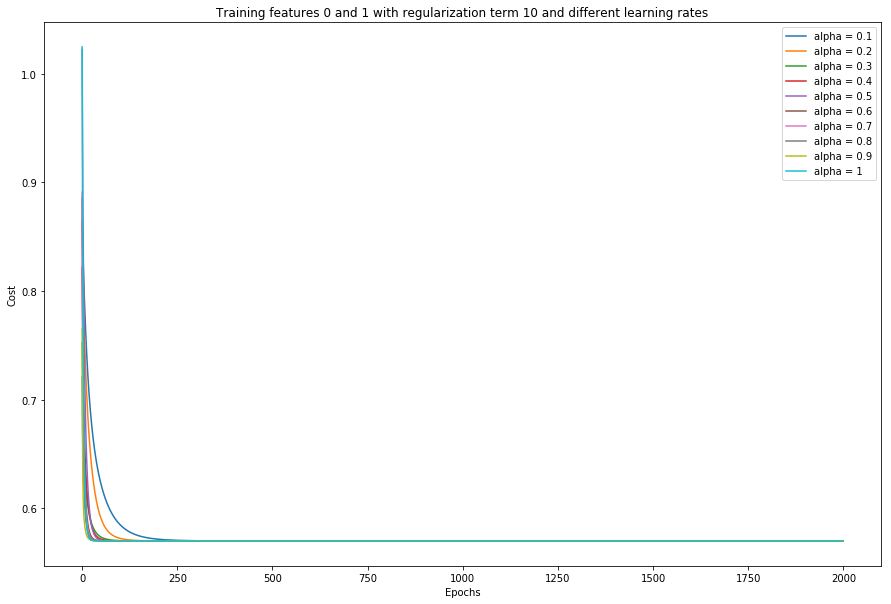

The cost in epoch 0 was 0.7974845903062568
The cost in epoch 500 was 0.6770591551444647
The cost in epoch 1000 was 0.6770591551444647
The cost in epoch 1500 was 0.6770591551444647
Finished training, trained during 2000
The cost in epoch 0 was 1.0847088490257202
The cost in epoch 500 was 0.6770591551444647
The cost in epoch 1000 was 0.6770591551444647
The cost in epoch 1500 was 0.6770591551444647
Finished training, trained during 2000
The cost in epoch 0 was 0.8905446703783165
The cost in epoch 500 was 0.6770591551444647
The cost in epoch 1000 was 0.6770591551444647
The cost in epoch 1500 was 0.6770591551444647
Finished training, trained during 2000
The cost in epoch 0 was 1.04520314870563
The cost in epoch 500 was 0.6770591551444647
The cost in epoch 1000 was 0.6770591551444647
The cost in epoch 1500 was 0.6770591551444647
Finished training, trained during 2000
The cost in epoch 0 was 1.1669232308877477
The cost in epoch 500 was 0.6770591551444647
The cost in epoch 1000 was 0.677059155

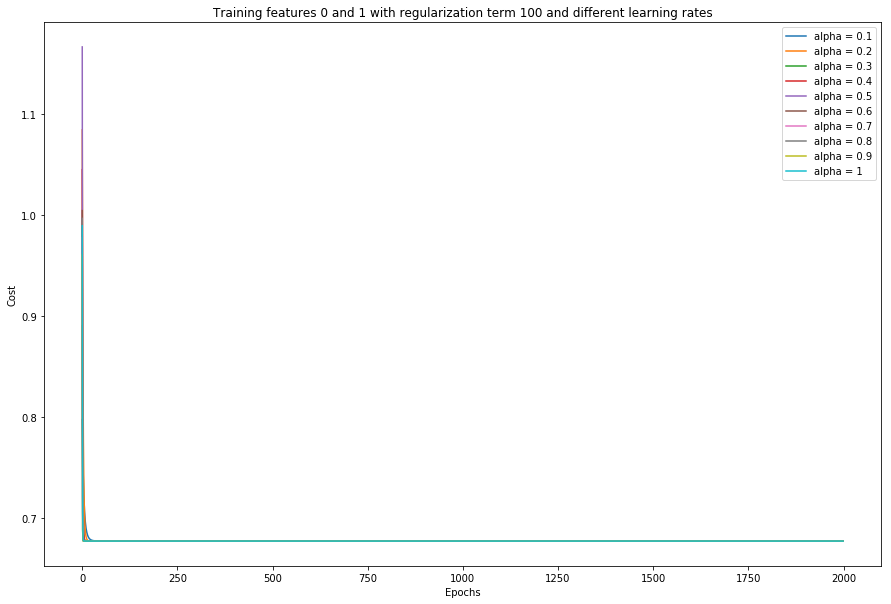

The cost in epoch 0 was 0.8334173235261979
The cost in epoch 500 was 0.15903887421307844
The cost in epoch 1000 was 0.08570452981728438
The cost in epoch 1500 was 0.059398482077602656
Finished training, trained during 2000
The cost in epoch 0 was 0.8155761621475146
The cost in epoch 500 was 0.08518247430785744
The cost in epoch 1000 was 0.045690007709684316
The cost in epoch 1500 was 0.031799304212813274
Finished training, trained during 2000
The cost in epoch 0 was 0.8328712270421184
The cost in epoch 500 was 0.05932933442694335
The cost in epoch 1000 was 0.03184171491097556
The cost in epoch 1500 was 0.022195912046803327
Finished training, trained during 2000
The cost in epoch 0 was 0.9350695579529966
The cost in epoch 500 was 0.04610918155057882
The cost in epoch 1000 was 0.02470300816097361
The cost in epoch 1500 was 0.017217480777456863
Finished training, trained during 2000
The cost in epoch 0 was 0.8599585440767354
The cost in epoch 500 was 0.03742367263907546
The cost in epoch 

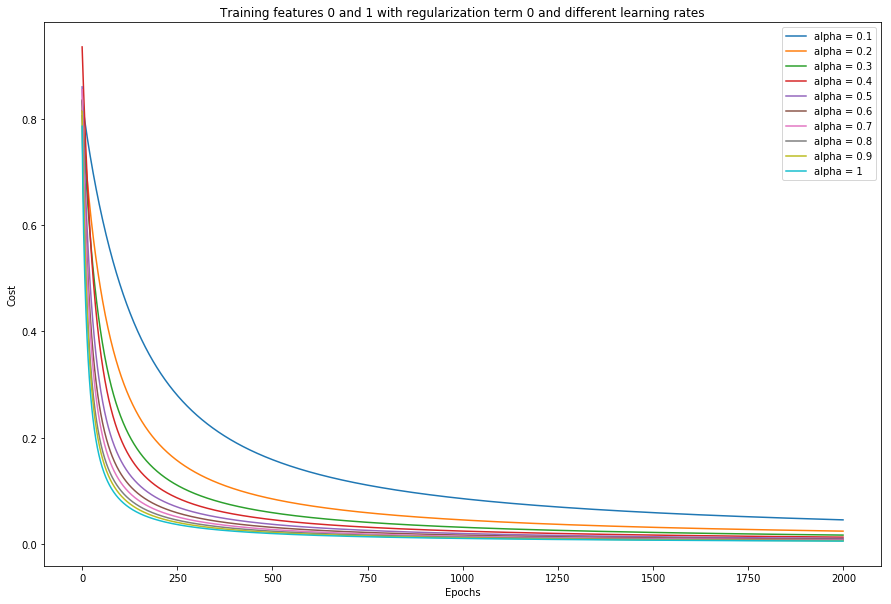

The cost in epoch 0 was 0.8656459096923882
The cost in epoch 500 was 0.26266329080633977
The cost in epoch 1000 was 0.23959977865033583
The cost in epoch 1500 was 0.2364691623225607
Finished training, trained during 2000
The cost in epoch 0 was 0.8430084172803849
The cost in epoch 500 was 0.23951103997625273
The cost in epoch 1000 was 0.2357876561791191
The cost in epoch 1500 was 0.23556894530381337
Finished training, trained during 2000
The cost in epoch 0 was 0.779387962611814
The cost in epoch 500 was 0.23640013778056157
The cost in epoch 1000 was 0.23557001467537952
The cost in epoch 1500 was 0.2355496428354953
Finished training, trained during 2000
The cost in epoch 0 was 0.7734372695545326
The cost in epoch 500 was 0.2357492121872909
The cost in epoch 1000 was 0.23555000629841266
The cost in epoch 1500 was 0.2355481584839249
Finished training, trained during 2000
The cost in epoch 0 was 0.7970869308586377
The cost in epoch 500 was 0.23561444415892627
The cost in epoch 1000 was 0.

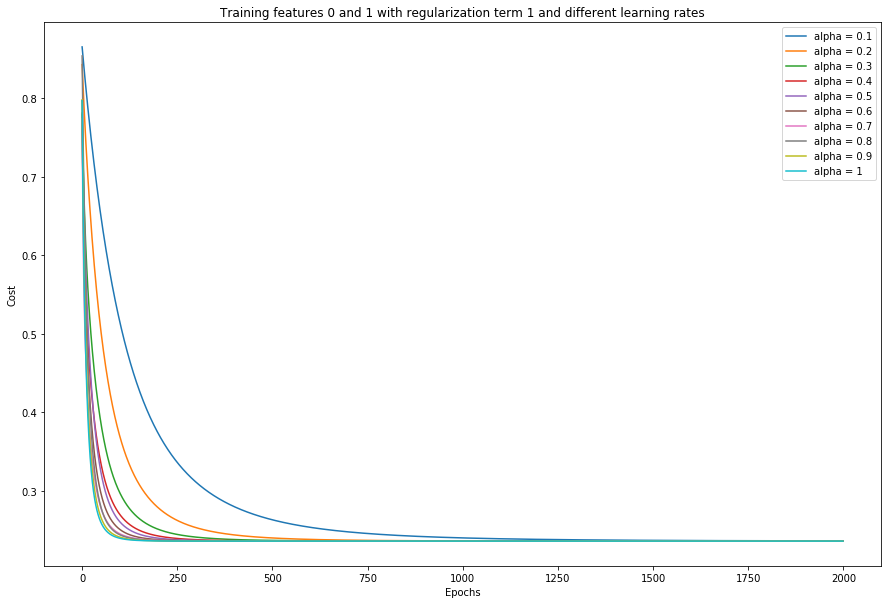

The cost in epoch 0 was 0.7975707431000448
The cost in epoch 500 was 0.5290942110122064
The cost in epoch 1000 was 0.5290511102286644
The cost in epoch 1500 was 0.5290510684109332
Finished training, trained during 2000
The cost in epoch 0 was 0.8000530069372628
The cost in epoch 500 was 0.5290511324121363
The cost in epoch 1000 was 0.5290510683872336
The cost in epoch 1500 was 0.5290510683865459
Finished training, trained during 2000
The cost in epoch 0 was 0.8775743385869289
The cost in epoch 500 was 0.5290510685215097
The cost in epoch 1000 was 0.529051068386546
The cost in epoch 1500 was 0.5290510683865458
Finished training, trained during 2000
The cost in epoch 0 was 0.8002881929976061
The cost in epoch 500 was 0.5290510683867732
The cost in epoch 1000 was 0.5290510683865458
The cost in epoch 1500 was 0.5290510683865458
Finished training, trained during 2000
The cost in epoch 0 was 0.8219688552378241
The cost in epoch 500 was 0.5290510683865421
The cost in epoch 1000 was 0.52905106

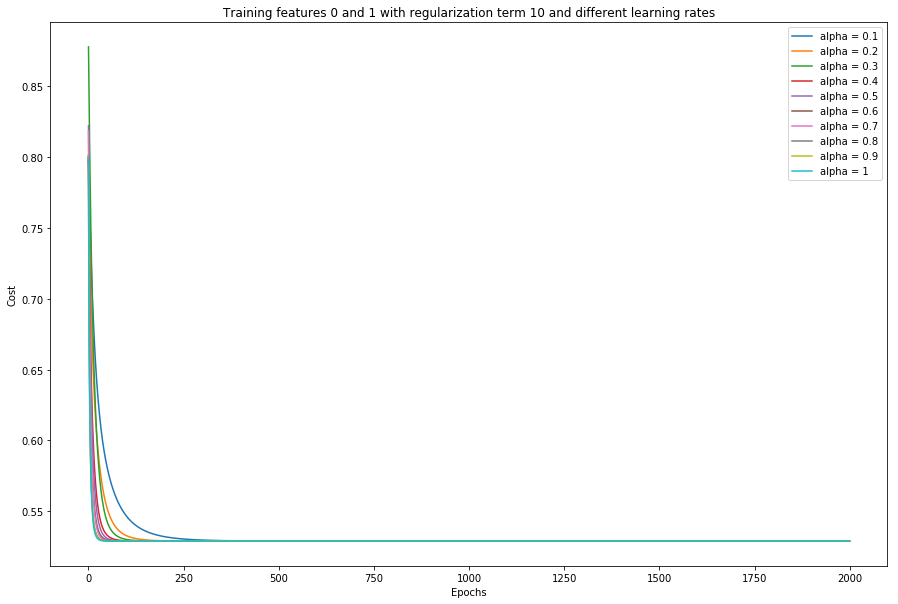

The cost in epoch 0 was 1.003691898550147
The cost in epoch 500 was 0.6687973664652531
The cost in epoch 1000 was 0.6687973664652531
The cost in epoch 1500 was 0.6687973664652531
Finished training, trained during 2000
The cost in epoch 0 was 0.8332588675739284
The cost in epoch 500 was 0.6687973664652532
The cost in epoch 1000 was 0.6687973664652532
The cost in epoch 1500 was 0.6687973664652532
Finished training, trained during 2000
The cost in epoch 0 was 0.879473032107488
The cost in epoch 500 was 0.6687973664652532
The cost in epoch 1000 was 0.6687973664652532
The cost in epoch 1500 was 0.6687973664652532
Finished training, trained during 2000
The cost in epoch 0 was 0.847118023616848
The cost in epoch 500 was 0.6687973664652532
The cost in epoch 1000 was 0.6687973664652532
The cost in epoch 1500 was 0.6687973664652532
Finished training, trained during 2000
The cost in epoch 0 was 0.962210645300362
The cost in epoch 500 was 0.6687973664652532
The cost in epoch 1000 was 0.66879736646

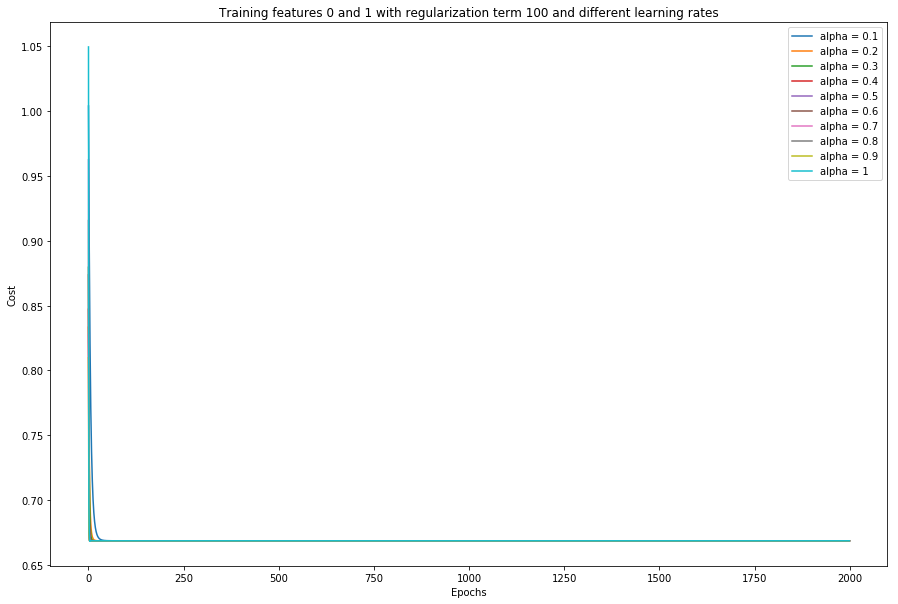

In [12]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10, 100] #Regularization term
for f1 in range(0,3): #1st feature
    f2=f1+1 #2nd feature
    train, test = generate_data_with_features(df, elements=100, features=[f1, f2], normalise=True)
    
    
    for l in lambdas:
        for i in range(0,10):

            weights, bias, costs = train_model(train, epochs=int(2000), learning_rate=alphas[i], regularization_term=l)
            p=plt.plot(costs, label='alpha = '+str(alphas[i]))
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
        plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
        plt.legend()
        plt.show()





As we can see here, the results of different features are quite similar since the data set seems to tend to overfitting. On one hand, for small regularization the model converges slowly and gets a small cost. On the other hand, for big regularization the model converges really fast but we get bigger cost. The bigger the learning rate, the faster it converges. Now, we provide a code to choose the features and the parameters in order to get a plot of the cost.

The cost in epoch 0 was 0.7798916716668478
The cost in epoch 500 was 0.037669977678589726
The cost in epoch 1000 was 0.02158167586078341
The cost in epoch 1500 was 0.015522156261611273
Finished training, trained during 2000


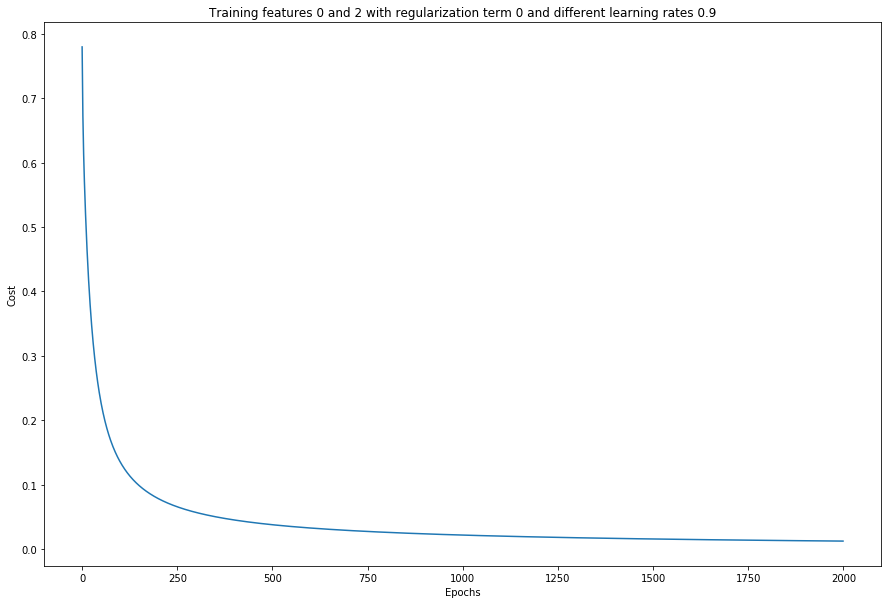

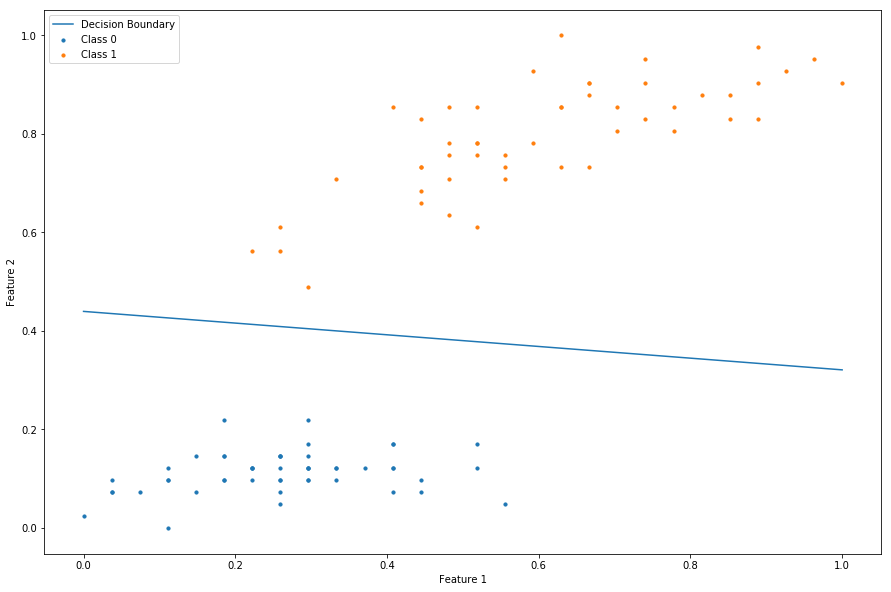

In [13]:
#Define the parameters
alphas=0.9
lambdas=0
epochs=2000

#Define features
f1=0
f2=2

train, test = generate_data_with_features(df, elements=100, features=[f1, f2], normalise=True)
weights, bias, costs = train_model(train, epochs=int(epochs), learning_rate=alphas, regularization_term=lambdas)

trainx,trainy=train


#Plot the cost
plt.plot(costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training features '+str(f1)+' and '+str(f2)+' with regularization term '+str(lambdas)+' and different learning rates '+str(alphas))
plt.savefig('figure with features '+str(f1)+str(f2)+'and lambda'+str(lambdas))
plt.show()

#Plot the decision boundary
plot_boundary(trainx.to_numpy(), trainy.to_numpy(), weights,bias)
plt.show()

## Part 2
In this part we use 80% of the Monk2 data set for training and 20% of the data set for testing. Firstly, we load the file and define the last 20% of the data set to be the testing instances.

In [96]:
monk = pd.DataFrame(loadmat('./data/monk2.mat')['monk2'])
test_elements = math.floor(len(monk) * 0.2)
monk.head()

,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,2,1
2,1,1,1,1,2,2,1
3,1,1,1,1,3,1,1
4,1,1,1,1,3,2,1


Now, we generate the data of training and testing. We will use features 0 and 4 because we know that we have 2 classes.

In [119]:
train, test = generate_data_with_features(monk, elements=346, features=[0, 4], normalise=True, test_elements=test_elements)

We try different values of learning rates (alphas) and different values of the regularization (lambdas). We cannot use huge values for the regularization term because we bump into convergence problems of the model.

The cost in epoch 0 was 1.0717477072125308
The cost in epoch 500 was 0.5998697347812998
The cost in epoch 1000 was 0.5984660027125367
The cost in epoch 1500 was 0.5980316549128313
The cost in epoch 2000 was 0.5978941557172566
The cost in epoch 2500 was 0.5978500659656119
The cost in epoch 3000 was 0.5978358238479939
The cost in epoch 3500 was 0.5978312038410079
The cost in epoch 4000 was 0.5978297015378121
The cost in epoch 4500 was 0.5978292123554544
The cost in epoch 5000 was 0.5978290529417123
The cost in epoch 5500 was 0.5978290009689307
The cost in epoch 6000 was 0.59782898402018
The cost in epoch 6500 was 0.5978289784922428
The cost in epoch 7000 was 0.5978289766891216
The cost in epoch 7500 was 0.5978289761009455
The cost in epoch 8000 was 0.5978289759090777
The cost in epoch 8500 was 0.597828975846488
The cost in epoch 9000 was 0.5978289758260701
The cost in epoch 9500 was 0.5978289758194095
Finished training, trained during 10000
The cost in epoch 0 was 0.8195468473232935
The 

The cost in epoch 7000 was 0.5978289758161848
The cost in epoch 7500 was 0.5978289758161848
The cost in epoch 8000 was 0.5978289758161848
The cost in epoch 8500 was 0.5978289758161848
The cost in epoch 9000 was 0.5978289758161848
The cost in epoch 9500 was 0.5978289758161848
Finished training, trained during 10000
The cost in epoch 0 was 0.8352151916286451
The cost in epoch 500 was 0.6449180811472469
The cost in epoch 1000 was 0.6448134322131834
The cost in epoch 1500 was 0.6448131060088317
The cost in epoch 2000 was 0.6448131049923405
The cost in epoch 2500 was 0.6448131049891729
The cost in epoch 3000 was 0.6448131049891632
The cost in epoch 3500 was 0.6448131049891632
The cost in epoch 4000 was 0.6448131049891632
The cost in epoch 4500 was 0.6448131049891632
The cost in epoch 5000 was 0.6448131049891632
The cost in epoch 5500 was 0.6448131049891632
The cost in epoch 6000 was 0.6448131049891632
The cost in epoch 6500 was 0.6448131049891632
The cost in epoch 7000 was 0.644813104989163

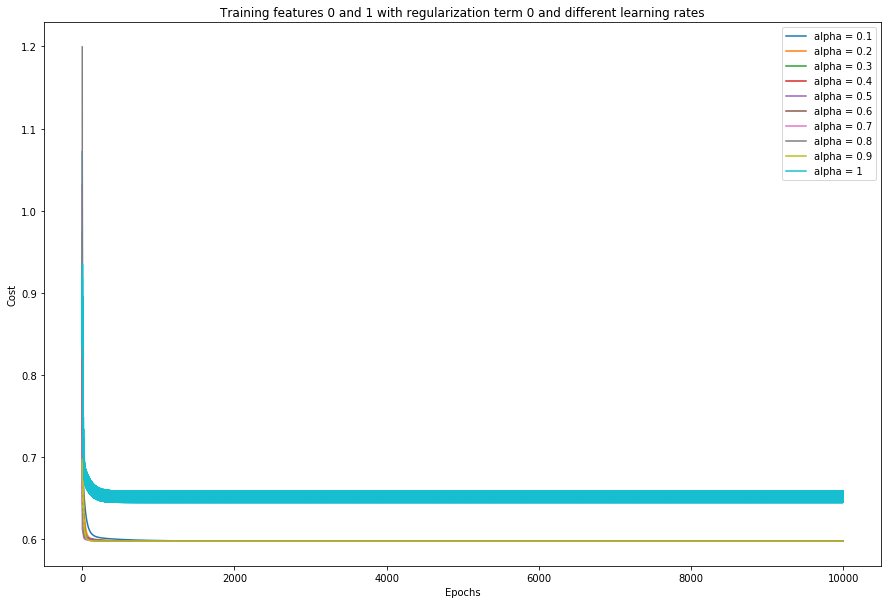

The cost in epoch 0 was 0.7036930920683684
The cost in epoch 500 was 0.6024420344389525
The cost in epoch 1000 was 0.6013033939873803
The cost in epoch 1500 was 0.6008730599418177
The cost in epoch 2000 was 0.6006949458052164
The cost in epoch 2500 was 0.6006176858922181
The cost in epoch 3000 was 0.6005833933275427
The cost in epoch 3500 was 0.6005680066208032
The cost in epoch 4000 was 0.6005610682481373
The cost in epoch 4500 was 0.6005579323752289
The cost in epoch 5000 was 0.6005565136159321
The cost in epoch 5500 was 0.6005558714269634
The cost in epoch 6000 was 0.6005555806839151
The cost in epoch 6500 was 0.6005554490409416
The cost in epoch 7000 was 0.6005553894328831
The cost in epoch 7500 was 0.6005553624417662
The cost in epoch 8000 was 0.600555350219813
The cost in epoch 8500 was 0.6005553446855202
The cost in epoch 9000 was 0.6005553421795006
The cost in epoch 9500 was 0.6005553410447323
Finished training, trained during 10000
The cost in epoch 0 was 0.7583164149946907
Th

The cost in epoch 7500 was 0.6005553401056631
The cost in epoch 8000 was 0.6005553401056631
The cost in epoch 8500 was 0.6005553401056631
The cost in epoch 9000 was 0.6005553401056631
The cost in epoch 9500 was 0.6005553401056631
Finished training, trained during 10000
The cost in epoch 0 was 1.7827213440061402
The cost in epoch 500 was 0.6677984220407462
The cost in epoch 1000 was 0.6677844100475512
The cost in epoch 1500 was 0.6677844030046006
The cost in epoch 2000 was 0.6677844030010608
The cost in epoch 2500 was 0.6677844030010589
The cost in epoch 3000 was 0.6677844030010589
The cost in epoch 3500 was 0.6677844030010589
The cost in epoch 4000 was 0.6677844030010589
The cost in epoch 4500 was 0.6677844030010589
The cost in epoch 5000 was 0.6677844030010589
The cost in epoch 5500 was 0.6677844030010589
The cost in epoch 6000 was 0.6677844030010589
The cost in epoch 6500 was 0.6677844030010589
The cost in epoch 7000 was 0.6677844030010589
The cost in epoch 7500 was 0.667784403001058

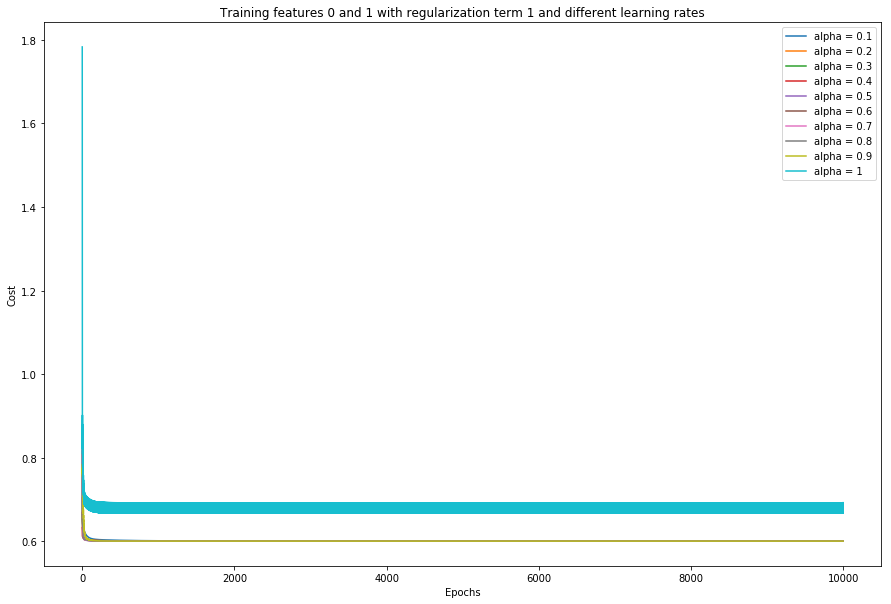

The cost in epoch 0 was 0.8587192563782676
The cost in epoch 500 was 0.6230565429210805
The cost in epoch 1000 was 0.6241023547955389
The cost in epoch 1500 was 0.6241816181586328
The cost in epoch 2000 was 0.6241874987392168
The cost in epoch 2500 was 0.624187934370332
The cost in epoch 3000 was 0.6241879666381543
The cost in epoch 3500 was 0.6241879690282588
The cost in epoch 4000 was 0.6241879692052955
The cost in epoch 4500 was 0.6241879692184089
The cost in epoch 5000 was 0.6241879692193802
The cost in epoch 5500 was 0.6241879692194521
The cost in epoch 6000 was 0.6241879692194575
The cost in epoch 6500 was 0.6241879692194577
The cost in epoch 7000 was 0.6241879692194577
The cost in epoch 7500 was 0.6241879692194577
The cost in epoch 8000 was 0.6241879692194577
The cost in epoch 8500 was 0.6241879692194577
The cost in epoch 9000 was 0.6241879692194577
The cost in epoch 9500 was 0.6241879692194577
Finished training, trained during 10000
The cost in epoch 0 was 1.5574865532207256
Th

The cost in epoch 7500 was 0.7090345655296778
The cost in epoch 8000 was 0.7090345655296778
The cost in epoch 8500 was 0.7090345655296778
The cost in epoch 9000 was 0.7090345655296778
The cost in epoch 9500 was 0.7090345655296778
Finished training, trained during 10000
The cost in epoch 0 was 0.7946054689917168
The cost in epoch 500 was 0.77417694554831
The cost in epoch 1000 was 0.7741769455484931
The cost in epoch 1500 was 0.7741769455484931
The cost in epoch 2000 was 0.7741769455484931
The cost in epoch 2500 was 0.7741769455484931
The cost in epoch 3000 was 0.7741769455484931
The cost in epoch 3500 was 0.7741769455484931
The cost in epoch 4000 was 0.7741769455484931
The cost in epoch 4500 was 0.7741769455484931
The cost in epoch 5000 was 0.7741769455484931
The cost in epoch 5500 was 0.7741769455484931
The cost in epoch 6000 was 0.7741769455484931
The cost in epoch 6500 was 0.7741769455484931
The cost in epoch 7000 was 0.7741769455484931
The cost in epoch 7500 was 0.7741769455484931


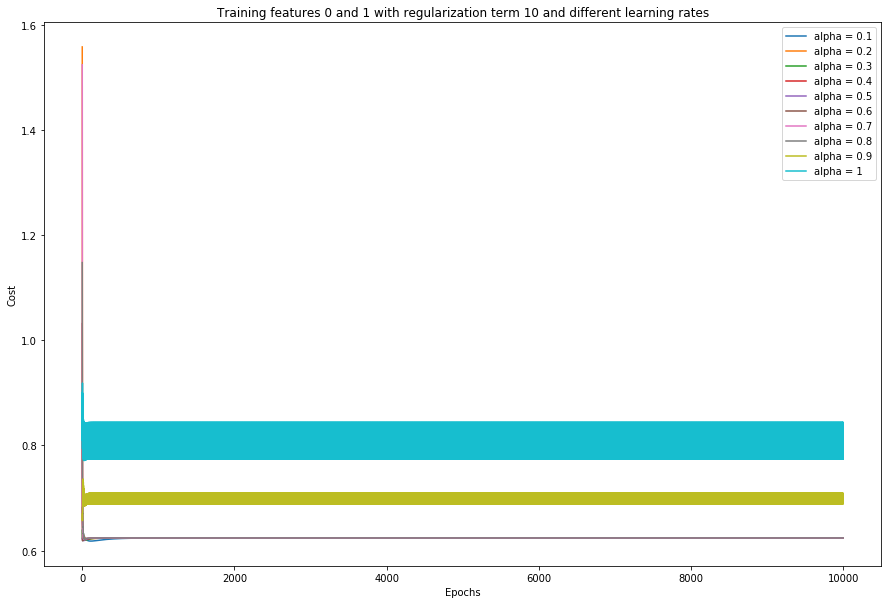

In [154]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10] #Regularization term

for l in lambdas:
    for i in range(0,10):

        weights, bias, costs = train_model(train, epochs=int(10000), learning_rate=alphas[i], regularization_term=l)
        p=plt.plot(costs, label='alpha = '+str(alphas[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
    plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
    plt.legend()
    plt.show()

It is interesting to note that for high values of the learning rate and high values of the regularization parameters the cost seems to be unstable. Thus, we stick with smaller values of the regularization and high values of the learning rate to guarantee fast convergence. Hence, in the following we give the error of  a model (with 0.95 learning rate and 0.73 regularization), the cost function and the decision boundary.

The cost in epoch 0 was 0.844908057371932
The cost in epoch 500 was 0.6302412908365838
The cost in epoch 1000 was 0.6302236612476352
The cost in epoch 1500 was 0.6302236469636378
The cost in epoch 2000 was 0.6302236469520653
The cost in epoch 2500 was 0.6302236469520561
The cost in epoch 3000 was 0.6302236469520561
The cost in epoch 3500 was 0.6302236469520561
The cost in epoch 4000 was 0.6302236469520561
The cost in epoch 4500 was 0.6302236469520561
The cost in epoch 5000 was 0.6302236469520561
The cost in epoch 5500 was 0.6302236469520561
The cost in epoch 6000 was 0.6302236469520561
The cost in epoch 6500 was 0.6302236469520561
The cost in epoch 7000 was 0.6302236469520561
The cost in epoch 7500 was 0.6302236469520561
The cost in epoch 8000 was 0.6302236469520561
The cost in epoch 8500 was 0.6302236469520561
The cost in epoch 9000 was 0.6302236469520561
The cost in epoch 9500 was 0.6302236469520561
The cost in epoch 10000 was 0.6302236469520561
The cost in epoch 10500 was 0.63022364

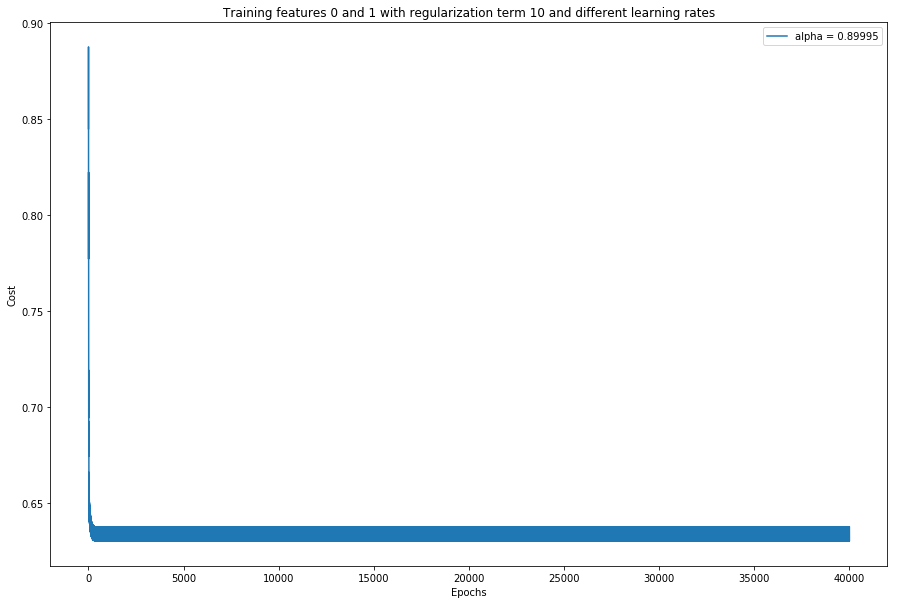

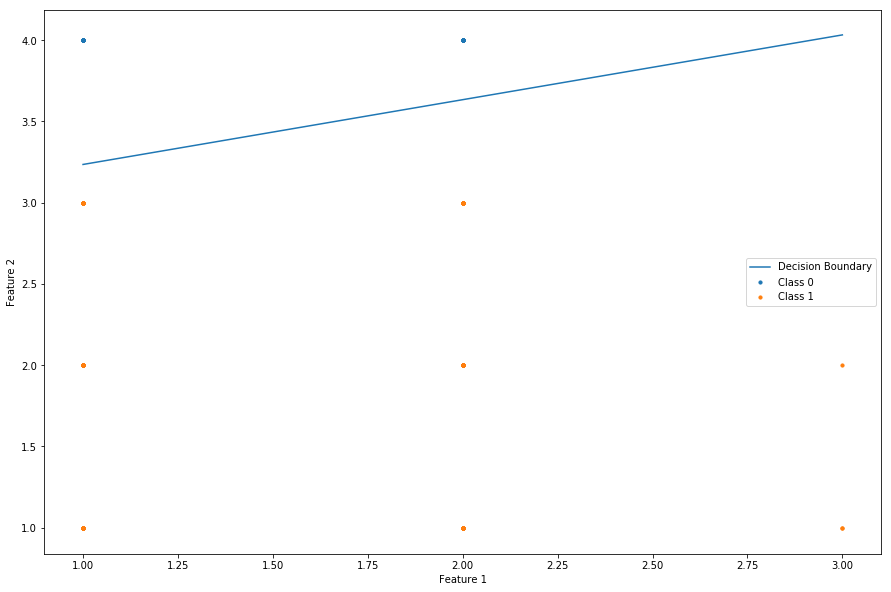

In [156]:
weights, bias, costs = train_model(train, epochs=40000, learning_rate=0.95, regularization_term=0.73)

print('Train error of the model is '+str(test_model(train, weights, bias)))
print('Test error of the model is '+str(test_model(test, weights, bias)))

#Cost of the model
plt.plot(costs, label='alpha = 0.89995')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
plt.legend()
plt.show()

#Decision Boundary
(plot_boundary(train[0].to_numpy(), train[1].to_numpy(), weights, bias))
plt.show()

It is hard to lower even more the errors of the model. However, since the training and testing errors are similar we believe that our model avoids overfitting thanks to the regularization term.

In [159]:
#get_prob_and_cost( test[0].to_numpy(),  test[1].to_numpy(), weights,bias)[0]

array([0.79637779, 0.66654949, 0.66654949, 0.50535793, 0.50535793,
       0.88442261, 0.79637779, 0.79637779, 0.66654949, 0.66654949,
       0.50535793, 0.50535793, 0.88442261, 0.88442261, 0.79637779,
       0.79637779, 0.66654949, 0.66654949, 0.50535793, 0.88442261,
       0.88442261, 0.79637779, 0.79637779, 0.66654949, 0.50535793,
       0.50535793, 0.88442261, 0.88442261, 0.79637779, 0.66654949,
       0.66654949, 0.50535793, 0.88442261, 0.88442261, 0.79637779,
       0.79637779, 0.66654949, 0.66654949, 0.50535793, 0.88442261,
       0.88442261, 0.79637779, 0.79637779, 0.66654949, 0.66654949,
       0.50535793, 0.50535793, 0.88442261, 0.88442261, 0.79637779,
       0.66654949, 0.66654949, 0.50535793, 0.50535793, 0.88442261,
       0.88442261, 0.79637779, 0.79637779, 0.66654949, 0.66654949,
       0.50535793, 0.88442261, 0.88442261, 0.79637779, 0.66654949,
       0.50535793, 0.88442261, 0.88442261, 0.79637779, 0.79637779,
       0.66654949, 0.66654949, 0.50535793, 0.88442261, 0.88442

In [157]:
#Plot Features ()

In [113]:
def plot_features(x: np.ndarray, y: np.ndarray) -> None:
    """
    Method that plot the data and the decision boundary of a given
    logistic regression model, using the bias term and the weights.
    :param x: features of the data
    :param y: classes of the data
    :param weights: weights of the model
    :param bias: bias of the model
    """
    # get the indexes of each class
    zero = np.where(y == 0)[1]
    one = np.where(y == 1)[1]

    plt.scatter(x[0][zero], x[1][zero], s=10, label='Class 0')
    plt.scatter(x[0][one], x[1][one], s=10, label='Class 1')

    
    plt.xlabel('Feature '+str(f1))
    plt.ylabel('Feature '+str(f2))
    plt.legend()
    plt.show()

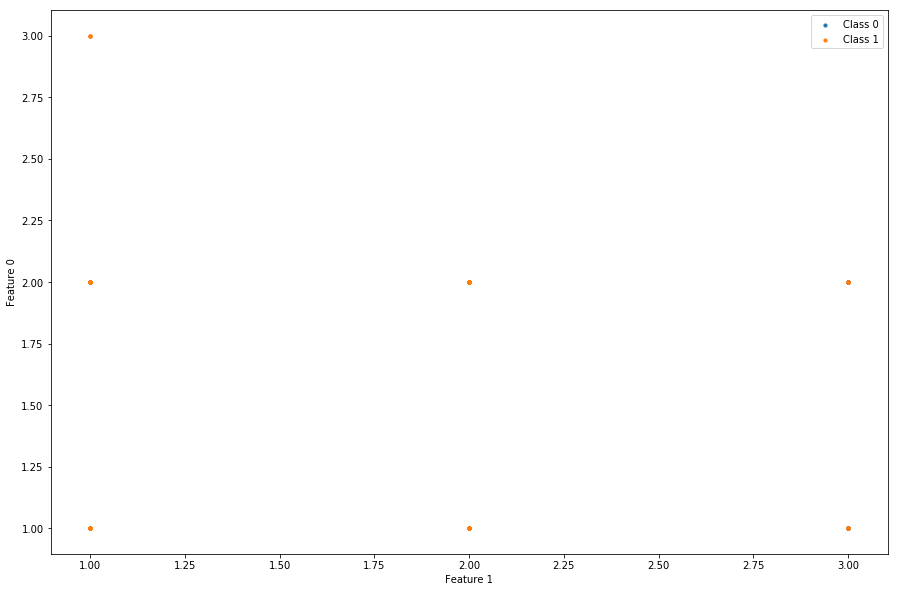

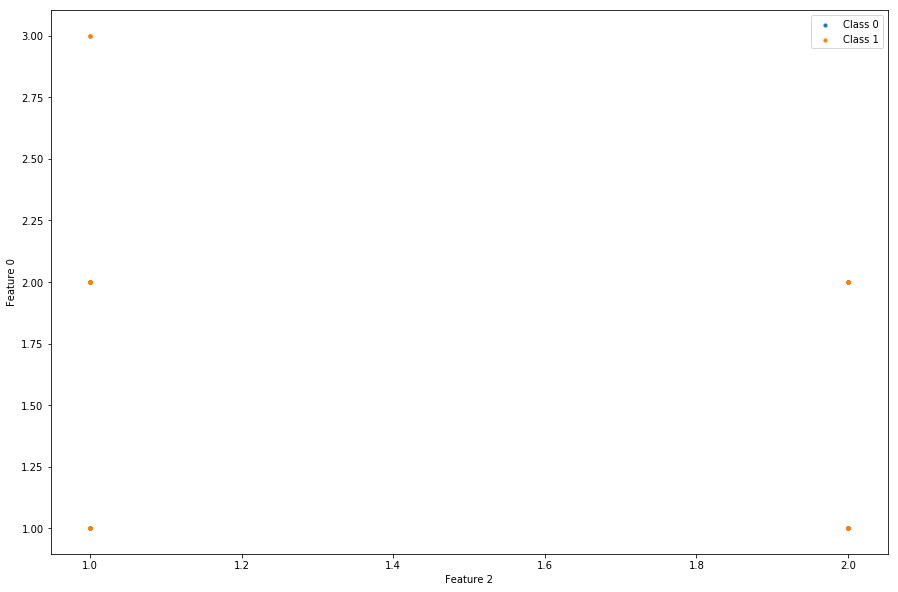

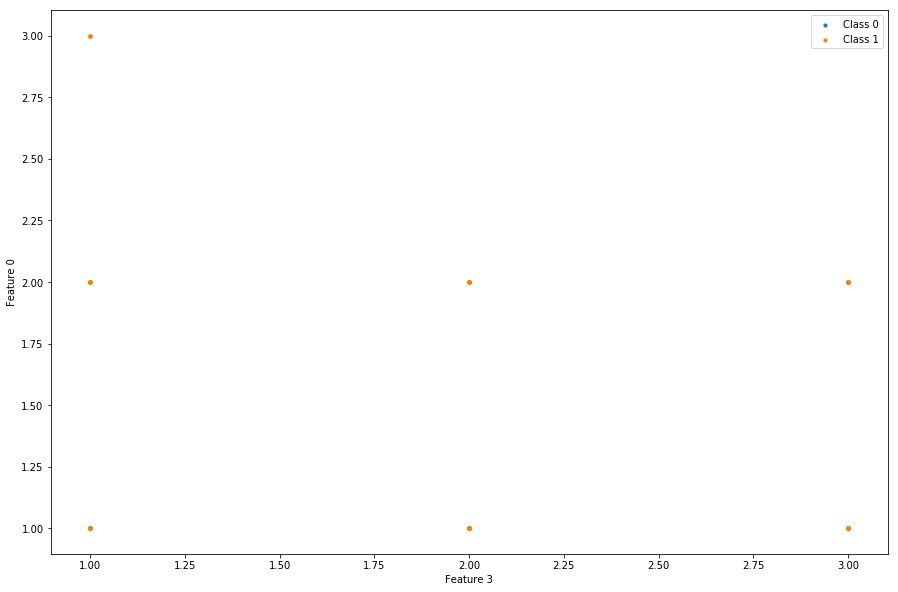

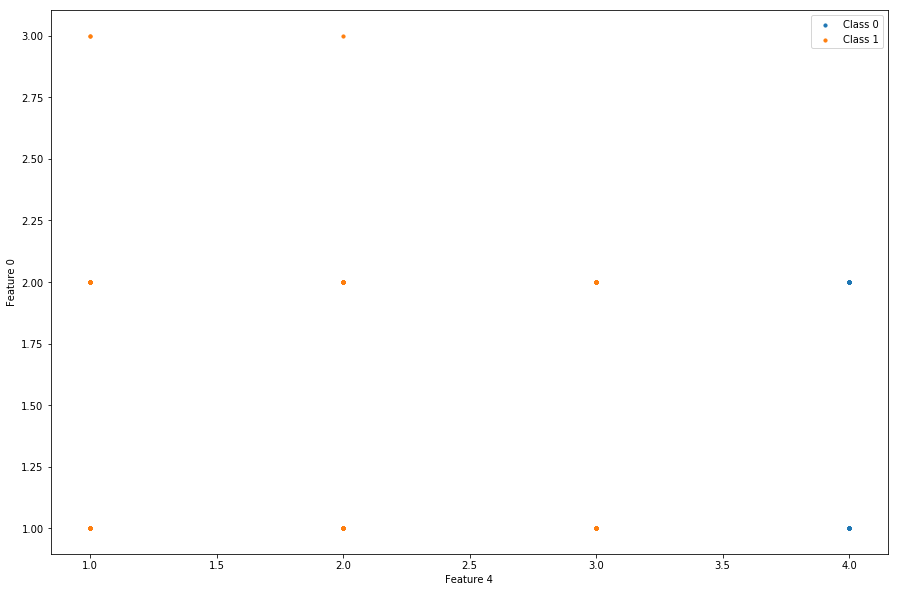

In [117]:
for f1 in range(1,5):
    f2=0
    train, test = generate_data_with_features(monk, elements=346, features=[f1, f2], normalise=True, test_elements=test_elements)
    plot_features(train[0].to_numpy(), train[1].to_numpy())